# 0.0 Imports

In [129]:
import numpy as np
import pandas as pd
import psycopg2 as pg
import sweetviz as sv
import seaborn as sns
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
import xgboost as xgb

## Helper Functions

In [242]:
def pie_chart(data,att,title,legend_title):
    
    def data_detail(pct, allvalues):
        absolute = int(pct/ 100.*np.sum(allvalues['response']))
        return "{:.0f}\n({:.1f}%)".format(absolute, pct)

    wedges, texts, autotexts = plt.pie( data = data,
                                       x = 'response',
                                       autopct = lambda pct: data_detail(pct, data),
                                       textprops = dict(color="w"))
    
    plt.legend( wedges, list(['No', 'Yes']),
              title = legend_title,
              loc="center left",
              bbox_to_anchor = (1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight="bold")
    plt.title(title,fontsize = 15);
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
#     sns.set()
    
jupyter_settings()


def precision_at_k(data, k):
    
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k,'precision_at_k']

def recall_at_k(data, k):

    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k,'recall_at_k']

def single_performance(model_name, x_validation, y_validation, yhat):

    data = x_validation.copy()
    data['response'] = y_validation.copy()

    # Propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clients by propensity score
    data = data.sort_values('score',ascending=False)
    
    return pd.DataFrame(
        {'Model Name': model_name,
        'Precision at K': precision_at_k(data,k=int(round(data.shape[0]*0.2,0))),
        'Recall at K': recall_at_k(data,k=int(round(data.shape[0]*0.2,0)))},
        index=[0]
    )

def cross_validation(data_train,k_fold,model_name, model,verbose):

    validation_size = int(round(data_train.shape[0]*0.2,0))
    
    precision_at_k_list = []
    recall_at_k_list = []

    for k in range(0,k_fold):

        start_validation = validation_size*k
        end_validation   = validation_size*(k+1)
        range_validation = arange(start_validation,end_validation)
        range_data       = arange(0,data_train.shape[0])

        validation = data_train.iloc[ start_validation:end_validation ]
        training = data_train[ ~isin(range_data,range_validation)]

        x_training = training.drop(['id','response'],axis=1)
        y_training = training['response'].copy()

        x_validation = validation.drop(['id','response'],axis=1)
        y_validation = validation['response'].copy()

        # model fit
        m = model.fit(x_training,y_training)

        # model predict
        y_hat = m.predict_proba(x_validation)
        
        data_val = x_validation.copy()
        data_val['response'] = y_validation.copy()

        # Propensity score
        data_val['score'] = y_hat[:,1].tolist()

        # sort clients by propensity score
        data_val = data_val.sort_values('score',ascending=False)
        
        precision_at_k_list.append(precision_at_k(data_val,int(round(data_val.shape[0]*0.2,0))))
        recall_at_k_list.append(recall_at_k(data_val,int(round(data_val.shape[0]*0.2,0))))
        
        if verbose:
            print(f'k_fold: {k}')
            print('Validation Size: {} | {} - {}'.format(validation.shape[0],start_validation,end_validation))
            print('Training Size: {}'.format(training.shape[0]))
            print('Total Size: {}'.format(validation.shape[0] + training.shape[0]))
            print('Total Original Size: {}'.format(data_train.shape[0]))
            print('Precision at K: {}'.format(precision_at_k(data_val,int(round(data_val.shape[0]*0.2,0)))))
            print('Recall at K:    {}'.format(recall_at_k(data_val,int(round(data_val.shape[0]*0.2,0)))))
            print('\n')
            
    return pd.DataFrame(
                        {'Model': model_name,
                         'Precision at K': round(np.mean(precision_at_k_list),4).astype(str) + ' +/- ' + round((np.std(precision_at_k_list)),4).astype(str),
                         'Recall at K':    round(np.mean(recall_at_k_list),4).astype(str) + ' +/- ' + round((np.std(recall_at_k_list)),4).astype(str)},
                          index=[0])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.1 Load Dataset

In [131]:
# Credentials

host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd =' cdspa'

# Connection with Database
conn_string = f'host={host} port={port} dbname={database} user={username} password={pwd}'
conn = pg.connect(conn_string)

# SQL Query
query = '''
    select * 
    from pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                       LEFT JOIN pa004.insurance i ON (u.id = i.id)
'''

df = pd.read_sql(query, conn)
conn.close()
df.head()

id  gender  age  region_code  policy_sales_channel  id  driving_license vehicle_age vehicle_damage  id  previously_insured  annual_premium  vintage  response
0   7    Male   23         11.0                 152.0   7                1    < 1 Year            Yes   7                   0         23367.0      249         0
1  13  Female   41         15.0                  14.0  13                1    1-2 Year             No  13                   1         31409.0      221         0
2  18  Female   25         35.0                 152.0  18                1    < 1 Year             No  18                   1         46622.0      299         0
3  31  Female   26          8.0                 160.0  31                1    < 1 Year             No  31                   0          2630.0      136         0
4  39    Male   45          8.0                 124.0  39                1    1-2 Year            Yes  39                   0         42297.0      264         0

In [132]:
print('Rows: {}'.format(df.shape[0]))
print('Columns: {}'.format(df.shape[1]))

Rows: 381109
Columns: 14


In [133]:
df_raw = df.loc[:,~df.columns.duplicated()]
df_raw.sample(3)

id  gender  age  region_code  policy_sales_channel  driving_license vehicle_age vehicle_damage  previously_insured  annual_premium  vintage  response
359478  208784    Male   22         33.0                 152.0                1    < 1 Year             No                   1         34358.0      251         0
317242  248845  Female   24         46.0                 152.0                1    < 1 Year            Yes                   0         35511.0       50         0
154067   88158    Male   57         28.0                 124.0                1    1-2 Year             No                   0         43289.0       92         0

In [134]:
print('Rows: {}'.format(df_raw.shape[0]))
print('Columns: {}'.format(df_raw.shape[1]))

Rows: 381109
Columns: 12


# 1.0 Data Description

In [135]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [136]:
print('Rows: {}'.format(df1.shape[0]))
print('Columns: {}'.format(df1.shape[1]))

Rows: 381109
Columns: 12


## 1.2 Data Types

In [137]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Change Types

In [138]:
# region_code
df1['region_code'] = df1['region_code'].astype('int64')

# policy_sales_channel 
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

In [139]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [140]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5 Data Descriptive

In [141]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [142]:
num_attributes = df1[['age','annual_premium','vintage']]
cat_attributes = df1[['gender','driving_license','vehicle_age','vehicle_damage','previously_insured','policy_sales_channel','region_code']]

### 1.5.1 Numerical atributes

In [143]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.mean)).T

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']

m

attributes     min       max     range          mean        median           std      skew   kurtosis
0             age    20.0      85.0      65.0     38.822584     38.822584     15.511591  0.672539  -0.565655
1  annual_premium  2630.0  540165.0  537535.0  30564.389581  30564.389581  17213.132474  1.766087  34.004569
2         vintage    10.0     299.0     289.0    154.347397    154.347397     83.671194  0.003030  -1.200688

### 1.5.2 Categorical atributes

In [144]:
for i in cat_attributes.columns:
    print(f'{i}: \nNumber of categories: {cat_attributes[i].unique().shape[0]}\nCategories: {sorted(cat_attributes[i].unique())}\n')

gender: 
Number of categories: 2
Categories: ['Female', 'Male']

driving_license: 
Number of categories: 2
Categories: [0, 1]

vehicle_age: 
Number of categories: 3
Categories: ['1-2 Year', '< 1 Year', '> 2 Years']

vehicle_damage: 
Number of categories: 2
Categories: ['No', 'Yes']

previously_insured: 
Number of categories: 2
Categories: [0, 1]

policy_sales_channel: 
Number of categories: 155
Categories: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 143, 144, 14

# 2.0 Feature Engineering

In [145]:
df2 = df1.copy()

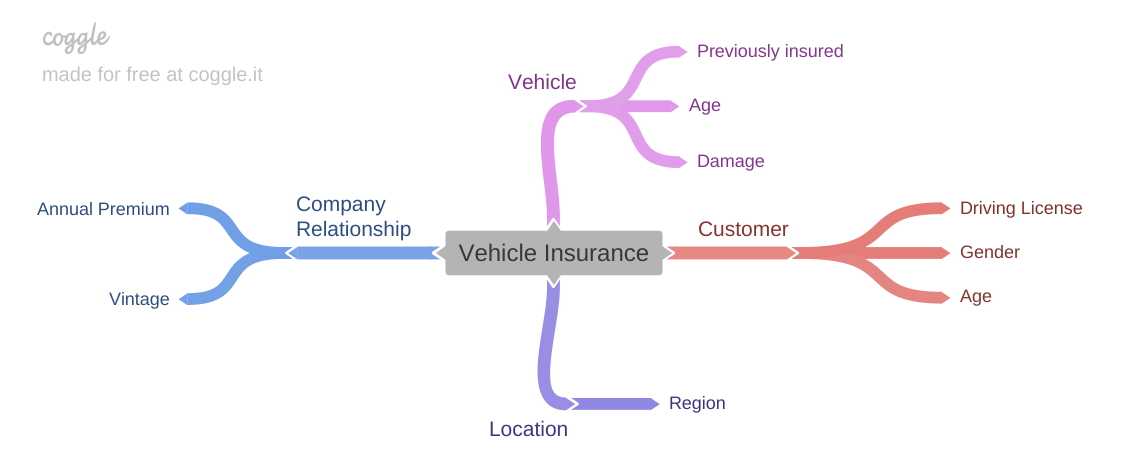

In [146]:
Image('img/Vehicle_Insurance.png')

## 2.1 Hyphotesis Mind Map

### 2.1.1 Customer's Hyphotesis

1. Customers over 40 years old are 50% more interest in vehicle insurance

### 2.1.2 Vehicle's Hyphotesis

1. Customer with a newer vehicle are 30% more interest in adquire the vericle insurance than customer with older cars

### 2.1.3 Company Relationship's Hyphotesis

1. Customer with less than 30 days in relation with the company are 40% more interest in adquire the vehicle insurance

## 2.2 Feature Criation

In [147]:
df2.head()

id  gender  age  region_code  policy_sales_channel  driving_license vehicle_age vehicle_damage  previously_insured  annual_premium  vintage  response
0   7    Male   23           11                   152                1    < 1 Year            Yes                   0         23367.0      249         0
1  13  Female   41           15                    14                1    1-2 Year             No                   1         31409.0      221         0
2  18  Female   25           35                   152                1    < 1 Year             No                   1         46622.0      299         0
3  31  Female   26            8                   160                1    < 1 Year             No                   0          2630.0      136         0
4  39    Male   45            8                   124                1    1-2 Year            Yes                   0         42297.0      264         0

In [148]:
# vericle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'bellow_1_year' if x == '< 1 Year' else 
                                                     'between_1_2_year' if x == '1-2 Year' else 
                                                     'over_2_years')

In [149]:
df2.head()

id  gender  age  region_code  policy_sales_channel  driving_license       vehicle_age vehicle_damage  previously_insured  annual_premium  vintage  response
0   7    Male   23           11                   152                1     bellow_1_year            Yes                   0         23367.0      249         0
1  13  Female   41           15                    14                1  between_1_2_year             No                   1         31409.0      221         0
2  18  Female   25           35                   152                1     bellow_1_year             No                   1         46622.0      299         0
3  31  Female   26            8                   160                1     bellow_1_year             No                   0          2630.0      136         0
4  39    Male   45            8                   124                1  between_1_2_year            Yes                   0         42297.0      264         0

# 3.0 Data Filtering

In [150]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis

In [151]:
df4 = df3.copy()

In [152]:
# report = sv.analyze(df4)
# report.show_html()

## 4.1. Univariate Analysis

### 4.1.1 Numerial Variables

#### 4.1.1.1 Age

- Although people between 20 and 30 years old are not usually interest, people between 40 and 50 years old are offen intereset

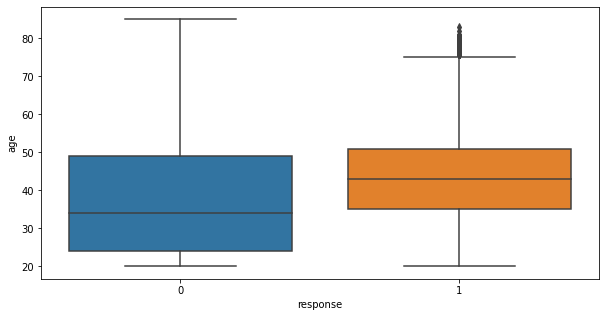

In [153]:
# 'age'
fig = plt.figure(figsize=(10,5))
sns.boxplot(x='response',y='age',data=df4);

##### Not Interesed

##### Interessed

In [252]:
aux00 = df4.loc[df4['response'] == 0, 'age']
# sns.histplot(aux00)
aux00

0         23
1         41
2         25
3         26
4         45
5         44
6         23
8         23
9         31
11        23
12        49
14        59
15        20
16        24
17        22
18        52
19        26
20        24
21        44
22        49
23        25
24        45
25        22
26        60
27        55
28        40
29        64
30        25
31        24
32        24
33        24
34        26
35        59
36        22
37        69
38        50
39        58
41        78
42        34
43        75
44        37
45        54
46        46
47        42
48        22
49        25
50        24
51        20
52        20
53        51
54        23
55        49
56        76
57        57
59        51
60        24
61        27
62        69
63        24
64        24
65        38
66        44
67        46
68        44
69        21
70        52
71        25
72        71
73        76
74        24
75        21
77        24
78        33
80        23
81        40
82        20
83        23

<AxesSubplot:xlabel='age', ylabel='Count'>

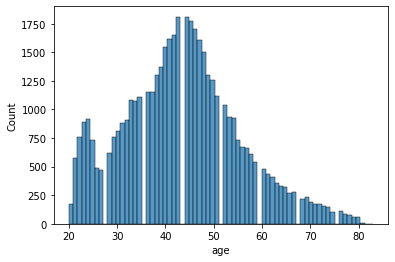

In [155]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux00)

#### 4.1.1.2 Annual Premium

- The distribuiton of annual premium are very similuar to interest and not interest people. Only the scale of this distribution are diferent

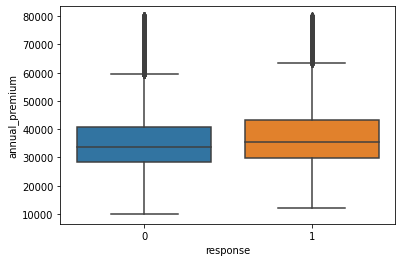

In [156]:
# 'annual_premium'
aux = df4[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000)]
sns.boxplot(x='response',y='annual_premium',data=aux);

##### Interesed

##### Not interessed

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

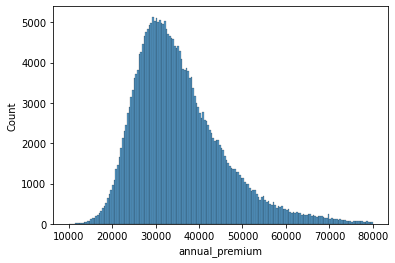

In [157]:
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux00)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

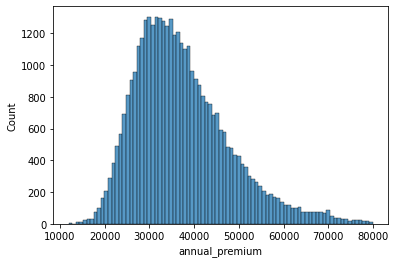

In [158]:
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux00)

#### 4.1.1.3 Vintage

- The vintage (days that the customer is related with the company) is uniform distribuited

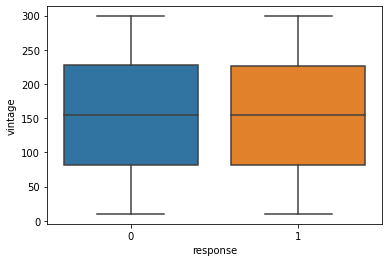

In [159]:
# 'annual_premium'
sns.boxplot(x='response',y='vintage',data=df4);

##### Not intereset

##### Intereset

<AxesSubplot:xlabel='vintage', ylabel='Count'>

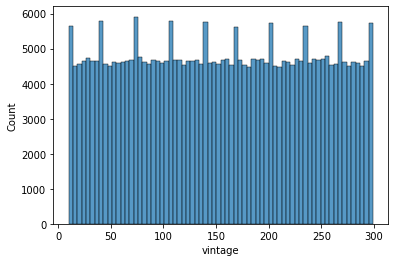

In [160]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

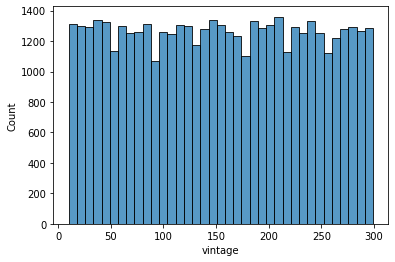

In [161]:
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux00)

### 4.1.2 Categorical Variables

#### 4.1.2.1 Gender

- Mens represents 54% of the elevible customer but represents 61% of whole car insurance interest

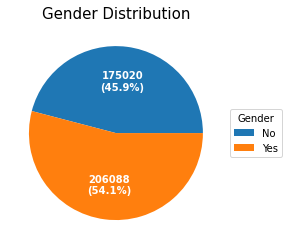

In [162]:
aux2 = pd.DataFrame(df4[['gender','response']].groupby('gender').count()).reset_index()
pie_chart(aux2,'gender',"Gender Distribution",'Gender')

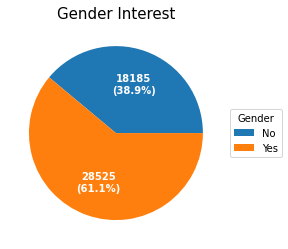

In [163]:
# pie plot
# ax = plt.figure(figsize=(15,6))
aux2 = pd.DataFrame(df4[['gender','response']].groupby('gender').sum()).reset_index()
pie_chart(aux2,'gender',"Gender Interest",'Gender')

#### 4.1.2.2 Driving License

- The majority people has driving license

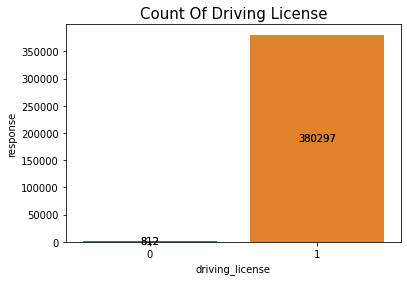

In [164]:
aux1 = df4[['driving_license','response']].groupby('driving_license').count().reset_index()
g = sns.barplot(x = 'driving_license', y = 'response', data = aux1)
g.set_title('Count Of Driving License',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'center',fontsize='medium',fmt='%.0f')
    g.bar_label(i, color='black', label_type= 'center',fontsize='medium',fmt='%.0f',)

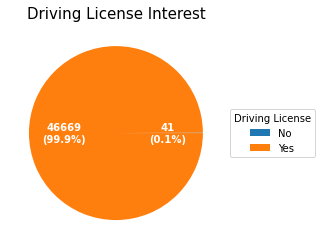

In [165]:
# pie plot
aux1 = pd.DataFrame(df4[['driving_license','response']].groupby('driving_license').sum()).reset_index()
pie_chart(aux1,'driving_license',"Driving License Interest",'Driving License')

#### 4.1.2.3 Region Code

- No region code has a significant majority of interest

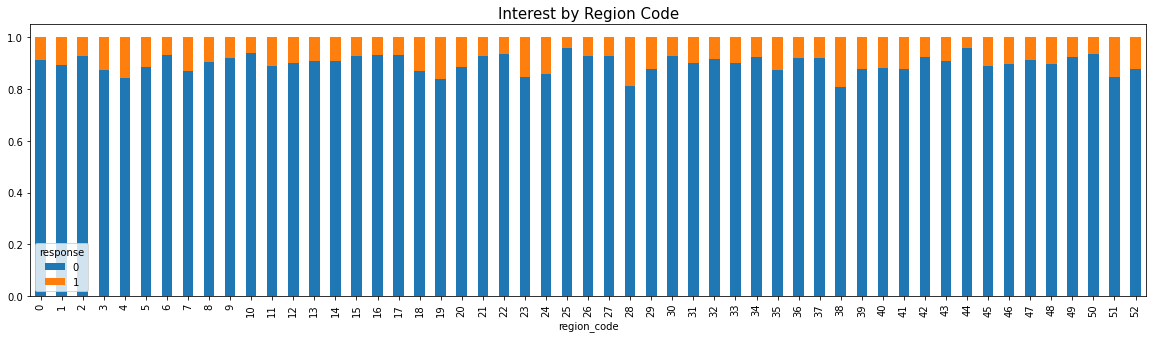

In [166]:
df_grouped = df4[["region_code", "response"]].groupby('region_code').value_counts(normalize=True).unstack('response')
df_grouped.plot.bar(stacked=True,figsize=(20,5));
plt.title('Interest by Region Code',fontsize=15);

#### 4.1.2.4 Previously Insured

- Although the similar number of people previously and not previously car insured, the people that haven't previoulsly insurance are the most interested

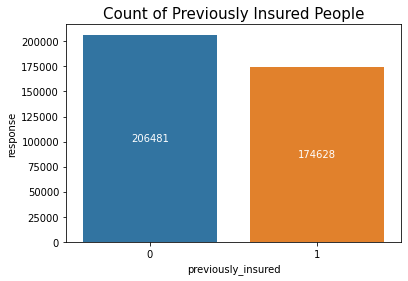

In [167]:
aux1 = df4[['previously_insured','response']].groupby('previously_insured').count().reset_index()
g = sns.barplot(x = 'previously_insured', y = 'response', data = aux1)
g.set_title('Count of Previously Insured People',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.0f')

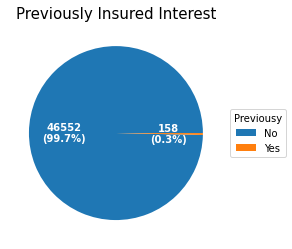

In [168]:
aux1 = pd.DataFrame(df4[['previously_insured','response']].groupby('previously_insured').sum()).reset_index()
pie_chart(aux1,'previously_insured',"Previously Insured Interest",'Previousy')

#### 4.1.2.5 Vericle Age

- THe majority of people has cars bellow 2 years old, but the more interested people has cars over 2 years

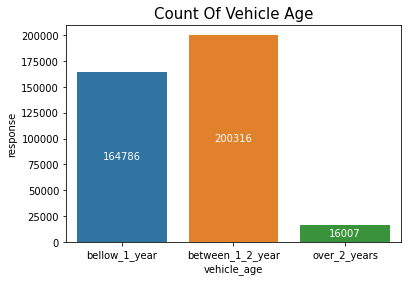

In [169]:
aux1 = df4[["vehicle_age", "response"]].groupby('vehicle_age').count().reset_index()
g = sns.barplot(x = 'vehicle_age', y = 'response', data = aux1)
g.set_title('Count Of Vehicle Age',fontsize=15)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.0f')

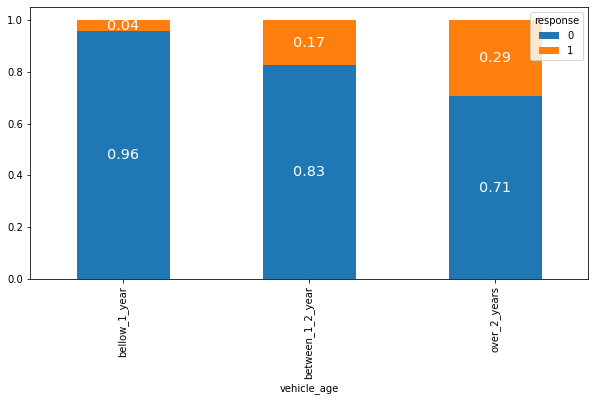

In [170]:
# 'vehicle_age'
df_grouped = df4[["vehicle_age", "response"]].groupby('vehicle_age').value_counts(normalize=True).unstack('response')
g = df_grouped.plot.bar(stacked=True,figsize=(10,5));

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.2f')

#### 4.1.2.6 Policy Sales Channel

- Although the quantity diference of sales channel, no channel has the majority of the interest people

In [171]:
# policy_sales_channel
aux0 = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
aux1 = aux0[aux0['response'] > 40.0]### 4.1.6 Previously Insured

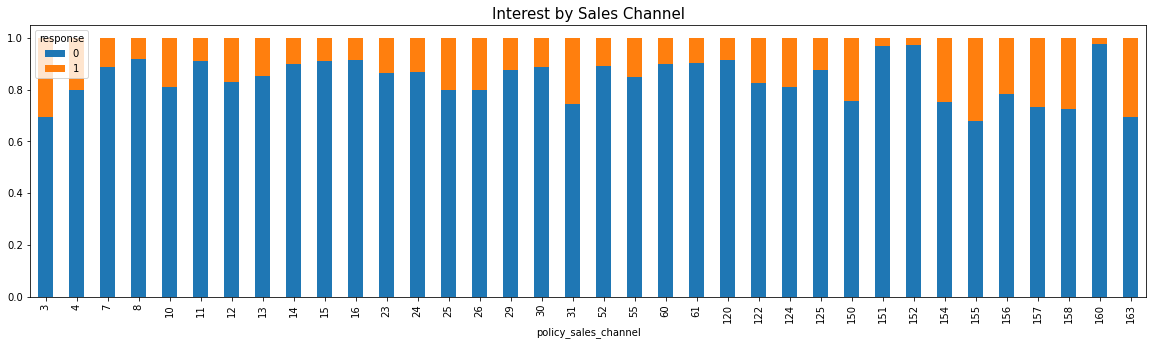

In [172]:
aux = df4[["policy_sales_channel", "response"]].groupby('policy_sales_channel').sum().reset_index()
aux = aux[aux['response'] > 40]

# 'policy_sales_channel'
aux2 = df4[df4['policy_sales_channel'].isin(aux['policy_sales_channel'])]
df_grouped = aux2[["policy_sales_channel", "response"]].groupby('policy_sales_channel').value_counts(normalize=True).unstack('response')
df_grouped.plot.bar(stacked=True,figsize=(20,5));
plt.title('Interest by Sales Channel',fontsize=15);

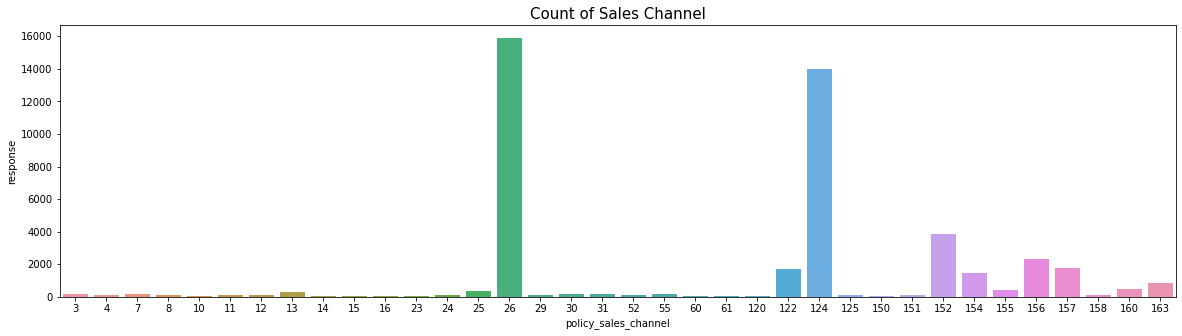

In [173]:
fig = plt.figure(figsize=(20,5))
aux = df4[["policy_sales_channel", "response"]].groupby('policy_sales_channel').sum().reset_index()
aux = aux[aux['response'] > 40]

sns.barplot(data=aux,x='policy_sales_channel',y='response');
plt.title('Count of Sales Channel',fontsize=15);

#### 4.1.2.7 Vehicle Damage

- Although tha simular number of damage and not damage vehicles, people that are more interest has a vehicle damage in the past

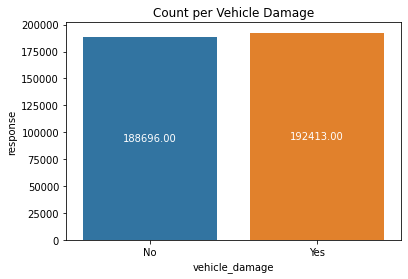

In [174]:
# 'vehicle_damage'
aux1 = df4[['vehicle_damage','response']].groupby('vehicle_damage').count().reset_index()
g = sns.barplot(x = 'vehicle_damage', y = 'response', data = aux1)
g.set_title('Count per Vehicle Damage')

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.2f')

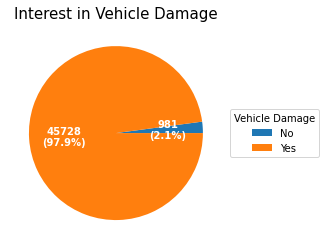

In [175]:
# pie plot
aux1 = pd.DataFrame(df4[['vehicle_damage','response']].groupby('vehicle_damage').sum()).reset_index()
pie_chart(aux1,'vehicle_damage',"Interest in Vehicle Damage",'Vehicle Damage')

## 4.2. Bivariate Analysis

### H1. Customers over 40 years old are 50% more interest in vehicle insurance

- **False**, customer over 40 years old are 48% more interest in vehicle insurance than others

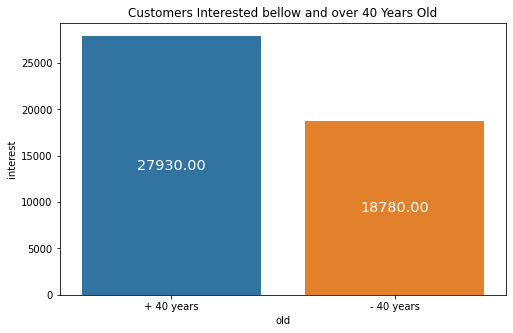

In [176]:
aux = df4[['age','response']].copy()
aux['old'] = df4['age'].apply(lambda x: '+ 40 years' if x > 40 else '- 40 years')
aux = aux[['old','response']].groupby('old').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(8,5))
g = sns.barplot(x='old', y='interest', data=aux)
plt.title('Customers Interested bellow and over 40 Years Old')

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.2f')

In [177]:
aux['perc'] = (round(aux['interest']/aux['interest'].sum()*100,2)).astype(str) + '%'
aux['diff'] = aux['interest'].rolling(window=2).apply(lambda x: round((x.iloc[0])*100/x.iloc[1]-100,2))
aux

old  interest    perc   diff
0  + 40 years     27930  59.79%    NaN
1  - 40 years     18780  40.21%  48.72

### H2. Customer with a newer vehicle are 30% more interest in adquire the vericle insurance than customer with older cars

- **False**, customer with newer vehicle are 81% less interest in adquive the insurance

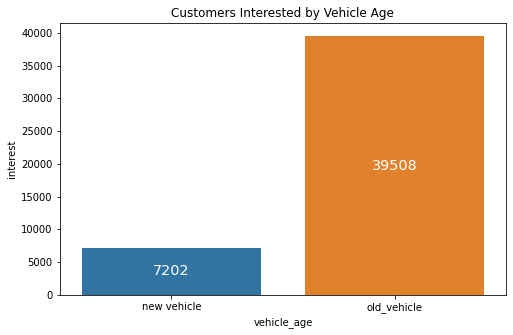

In [178]:
aux = df4[['vehicle_age','response']].copy()
aux['vehicle_age'] = aux['vehicle_age'].apply(lambda x: 'new vehicle' if x == 'bellow_1_year' else 'old_vehicle')
aux = aux.groupby('vehicle_age').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(8,5))
g = sns.barplot(x='vehicle_age', y='interest', data=aux)
plt.title('Customers Interested by Vehicle Age')

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.0f')

In [179]:
aux['perc'] = (round(aux['interest']/aux['interest'].sum()*100,2)).astype(str) + '%'
aux['diff'] = aux['interest'].rolling(window=2).apply(lambda x: round((x.iloc[0])*100/x.iloc[1]-100,2))
aux

vehicle_age  interest    perc   diff
0  new vehicle      7202  15.42%    NaN
1  old_vehicle     39508  84.58% -81.77

### H3. Customer with more days in relation with the company are more interest in adquire the vehicle insurance

- **False**, as longer as the customer relationship with the company are, the lower is the interest

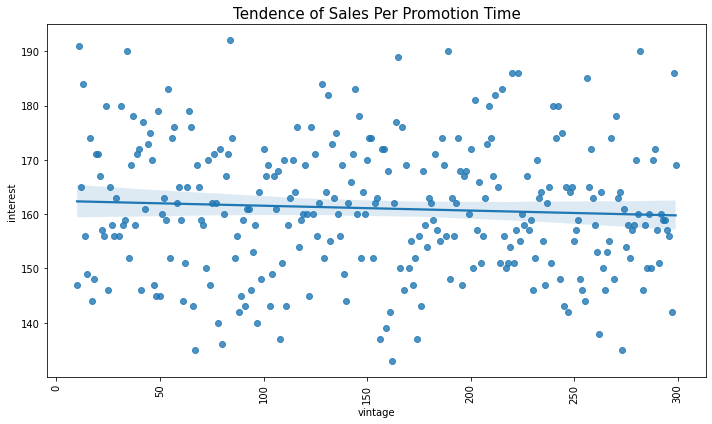

In [180]:
aux = df4[['vintage','response']].copy()
aux = aux.groupby('vintage').sum().reset_index().rename(columns={'response':'interest'})

fig = plt.figure(figsize=(10,6))
sns.regplot(x='vintage', y='interest',data=aux);
plt.xticks(rotation=90);
plt.title('Tendence of Sales Per Promotion Time',fontsize=15)
plt.tight_layout()

# 5.0 Data Preparation

In [287]:
df5 = df4.copy()

## 5.1 Split Datasets

### 5.1.1 Test and Training

In [288]:
X = df4.drop(['response'],axis=1)
y = df4['response'].copy()

X_train, X_test, Y_train, Y_test = ms.train_test_split(X, y, test_size=0.1)

### 5.1.2 Training and Validation

In [289]:
x_train, x_validation, y_train, y_validation = ms.train_test_split(X_train, Y_train, test_size=0.2)

data_train = pd.concat([x_train, y_train], axis=1)

In [290]:
print('Total Dimension:            {}'.format(X.shape[0]))
print('Training Dataset Dimension: {} ({}%)'.format(X_train.shape[0],round((X_train.shape[0]/X.shape[0])*100,2)))
print('Test Dataset Dimension:     {} ({}%)'.format(X_test.shape[0],round((X_test.shape[0]/X.shape[0])*100,2)))

Total Dimension:            381109
Training Dataset Dimension: 342998 (90.0%)
Test Dataset Dimension:     38111 (10.0%)


## 5.2 Standardization

In [291]:
ss = pp.StandardScaler()

## annual_premium
data_train['annual_premium'] = ss.fit_transform(data_train[['annual_premium']].values)

## 5.3 Rescaling

In [292]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

## age
data_train['age'] = mms_age.fit_transform( data_train[['age']].values )

## vintage
data_train['vintage'] = mms_vintage.fit_transform( data_train[['vintage']].values )

## 5.4 Encoder

### 5.4.1 One Hot Enconding

In [293]:
## vehicle_age
data_train = pd.get_dummies(data_train, prefix='vehicle_age',columns=['vehicle_age'])

### 5.4.2 Target Enconding

In [294]:
# gender 
target_encode_gender = data_train.groupby('gender')['response'].mean()
data_train.loc[:,'gender'] = data_train['gender'].map(target_encode_gender)

# region_code 
target_encode_region_code = data_train.groupby('region_code')['response'].mean()
data_train.loc[:,'region_code'] = data_train['region_code'].map(target_encode_region_code)

# vehicle damage
target_encode_vehicle_damage = data_train.groupby('vehicle_damage')['response'].mean()
data_train.loc[:,'vehicle_damage'] = data_train['vehicle_damage'].map(target_encode_vehicle_damage)

### 5.4.3 Frequency Enconding

In [295]:
## policy_sales_channel 
fe_policy_sales_channel = data_train.groupby('policy_sales_channel').size()/len(data_train)
data_train.loc[:,'policy_sales_channel'] = data_train['policy_sales_channel'].map(fe_policy_sales_channel)

In [296]:
data_train.head()

id    gender       age  region_code  policy_sales_channel  driving_license  vehicle_damage  previously_insured  annual_premium   vintage  response  vehicle_age_bellow_1_year  vehicle_age_between_1_2_year  vehicle_age_over_2_years
373189  317770  0.104206  0.553846     0.058078              0.015663                1        0.237404                   0       -0.153546  0.577855         0                          0                             1                         0
160878  141815  0.138058  0.861538     0.188312              0.002730                1        0.005251                   1        0.829185  0.979239         0                          0                             1                         0
25670   204822  0.104206  0.492308     0.188312              0.194513                1        0.237404                   0        1.114283  0.038062         1                          0                             1                         0
283103  356652  0.104206  0.369231     0.188312              0.209327                1        0.237404                   0        1.648060  0.100346         1                          0                             1                         0
181296  306064  0.104206  0.107692     0.099353              0.353301                1        0.237404                   0       -1.618003  0.809689         0                          1                             0                         0

## 5.5 Validation Preparation

In [297]:
x_validation.head()

id  gender  age  region_code  policy_sales_channel  driving_license       vehicle_age vehicle_damage  previously_insured  annual_premium  vintage
162604  155265  Female   21           28                   157                1     bellow_1_year            Yes                   0          2630.0      170
271755  265450    Male   20           46                   160                1     bellow_1_year            Yes                   1          2630.0      242
127968  259409    Male   43           29                   154                1  between_1_2_year             No                   0         25960.0      207
137207  334748  Female   48           21                    26                1  between_1_2_year            Yes                   0          2630.0      199
73761   207142    Male   28           28                   152                1     bellow_1_year             No                   1         56315.0      165

In [298]:
def data_preparation(data,ss,mms_age,mms_vintage,target_encode_gender,target_encode_region_code,target_encode_vehicle_damage,fe_policy_sales_channel):

    # ==============================
    # ======= Standarization
    # annual_premium
    data.loc[:,'annual_premium'] = ss.fit_transform(data[['annual_premium']].values)

    # ==============================
    # ======= Rescaling
    # age
    data.loc[:,'age'] = mms_age.fit_transform(data[['age']].values)
    # vintage
    data.loc[:, 'vintage'] = mms_vintage.fit_transform(data[['vintage']].values)
    ,
    # ==============================
    # ====== One Hot Enconding 
    # vehicle_age
    data = pd.get_dummies(data, prefix = 'vehicle_age',columns=['vehicle_age'])

    # ==============================
    # ====== Target Enconding 
    # gender
    data.loc[:,'gender'] = data.loc[:,'gender'].map(target_encode_gender)
    # region_code
    data.loc[:,'region_code'] = data.loc[:,'region_code'].map(target_encode_region_code)
    # vehicle_damage
    data.loc[:,'vehicle_damage'] = data.loc[:,'vehicle_damage'].map(target_encode_vehicle_damage)

    # ==============================
    # ====== Frequency Enconding 
    # policy_sales_channel
    data.loc[:,'policy_sales_channel'] = data['policy_sales_channel'].map(fe_policy_sales_channel)

    # fillna
    data = data.fillna(0)
    
    return data
    
x_validation = data_preparation(x_validation,ss,mms_age,mms_vintage,target_encode_gender,target_encode_region_code,target_encode_vehicle_damage,fe_policy_sales_channel)

In [299]:
x_validation.head()

id    gender       age  region_code  policy_sales_channel  driving_license  vehicle_damage  previously_insured  annual_premium   vintage  vehicle_age_bellow_1_year  vehicle_age_between_1_2_year  vehicle_age_over_2_years
162604  155265  0.104206  0.015385     0.188312              0.017631                1        0.237404                   0       -1.637237  0.553633                          1                             0                         0
271755  265450  0.138058  0.000000     0.103251              0.057205                1        0.237404                   1       -1.637237  0.802768                          1                             0                         0
127968  259409  0.138058  0.353846     0.122899              0.015663                1        0.005251                   0       -0.269275  0.681661                          0                             1                         0
137207  334748  0.104206  0.430769     0.068932              0.209327                1        0.237404                   0       -1.637237  0.653979                          0                             1                         0
73761   207142  0.138058  0.123077     0.188312              0.353301                1        0.005251                   1        1.510602  0.536332                          1                             0                         0

# 6.0 Feature Selection

## 6.1 Feature Importance

In [300]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = data_train.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking')
df = pd.DataFrame()
for i, j in zip(x_train_n.columns, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df= pd.concat([df, aux], axis=0)

df = df.sort_values('importance',ascending=False)

Feature ranking


In [301]:
df

feature  importance
0                       vintage    0.271743
0                annual_premium    0.242697
0                           age    0.167063
0                   region_code    0.107296
0                vehicle_damage    0.067511
0          policy_sales_channel    0.059076
0            previously_insured    0.056619
0     vehicle_age_bellow_1_year    0.013994
0  vehicle_age_between_1_2_year    0.006128
0                        gender    0.005109
0      vehicle_age_over_2_years    0.002273
0               driving_license    0.000491

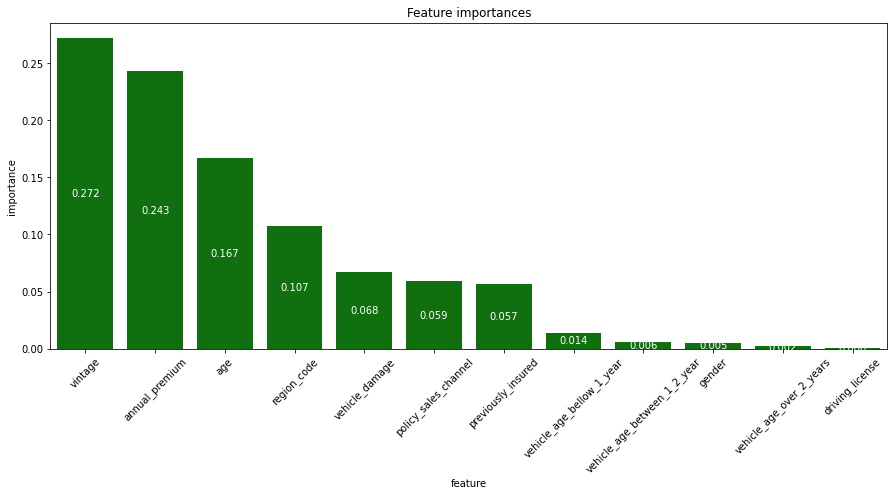

In [302]:
# plot the impurity-based feature importance of the forest

plt.figure(figsize=(15,6))
plt.title('Feature importances')
g = sns.barplot(x='feature',y='importance',data=df,color='green')
plt.xticks(rotation=45)

for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize='medium',fmt='%.3f')

# 7.0 Machine Learning

In [303]:
cols_selected = ['vintage',
                'annual_premium',
                'age',
                'region_code',
                'vehicle_damage',
                'policy_sales_channel',
                'previously_insured']

x_train = data_train[cols_selected]
x_val = x_validation[cols_selected]

## 7.1 KNN

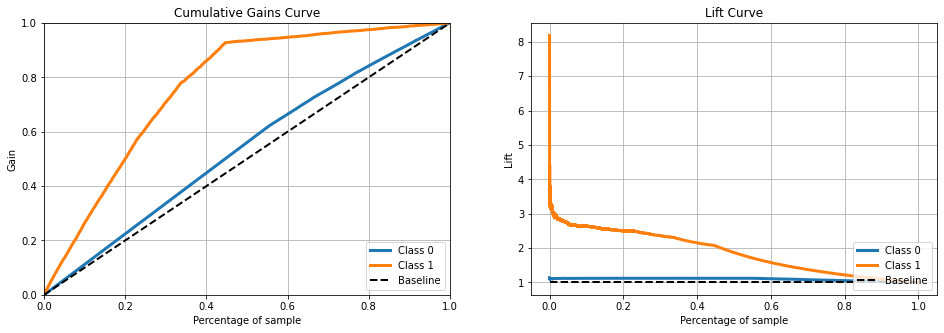

In [304]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=10)

# model training
knn_model.fit(x_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(x_val)

# performance
knn_result = single_performance('KNN', x_validation, y_validation,yhat_knn)

# plot
fig, ax = plt.subplots(1,2,figsize=(16,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,yhat_knn,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,yhat_knn,ax=ax[1]);

## 7.2 Logistic Regressor

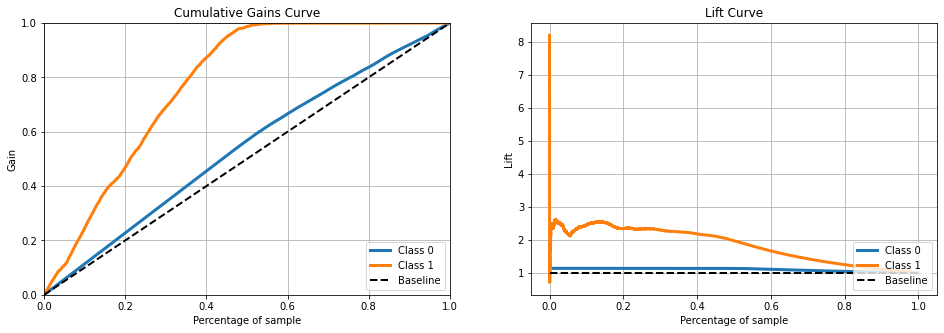

In [305]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training 
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

# performance
log_reg_result = single_performance('Logistic Regression', x_validation, y_validation,yhat_lr)

# plot
fig, ax = plt.subplots(1,2,figsize=(16,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,yhat_lr,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_validation,yhat_lr,ax=ax[1]);

## 7.3 Extra Trees

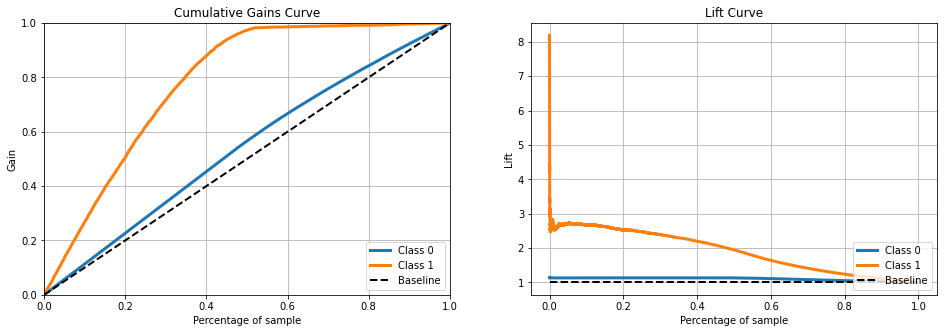

In [306]:
# model definition
et = en.ExtraTreesClassifier(n_estimators = 100, n_jobs=-1, random_state=42)

# model fit
et.fit(x_train, y_train)

# model predict
yhat_et = et.predict_proba(x_val)

# performance
extra_tree_result = single_performance('Extra Tree', x_validation, y_validation,yhat_et)

# plot
fig, ax = plt.subplots(1,2,figsize=(16,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,yhat_et,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,yhat_et,ax=ax[1]);

## 7.4 XGBoost

In [314]:
x_train.head()

vintage  annual_premium       age  region_code  vehicle_damage  policy_sales_channel  previously_insured
373189  0.577855       -0.153546  0.553846     0.058078        0.237404              0.015663                   0
160878  0.979239        0.829185  0.861538     0.188312        0.005251              0.002730                   1
25670   0.038062        1.114283  0.492308     0.188312        0.237404              0.194513                   0
283103  0.100346        1.648060  0.369231     0.188312        0.237404              0.209327                   0
181296  0.809689       -1.618003  0.107692     0.099353        0.237404              0.353301                   0

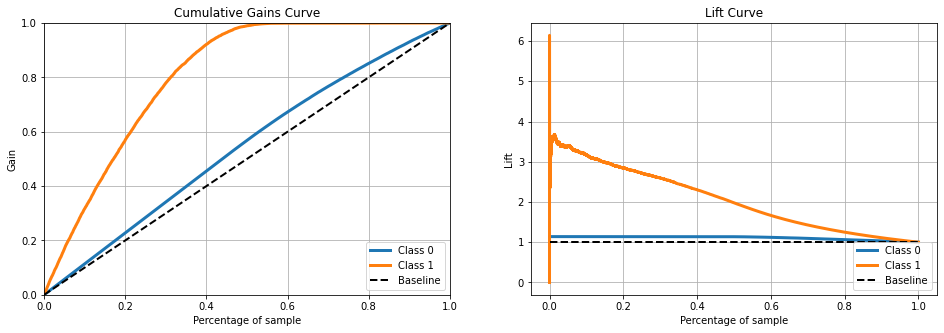

In [307]:
# model definition
xgb_model = xgb.XGBClassifier(n_estimators = 100)

# model fit
xgb_model.fit(x_train,y_train)

# model predict
yhat_xgb = xgb_model.predict_proba(x_val)

# performance
xgb_result = single_performance('XGBoost', x_validation, y_validation,yhat_xgb)

# plot
fig, ax = plt.subplots(1,2,figsize=(16,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,yhat_xgb,ax=ax[0])
skplt.metrics.plot_lift_curve(y_validation,yhat_xgb,ax=ax[1]);

## 7.5 Model Single Performance

In [308]:
pd.concat([knn_result, log_reg_result, extra_tree_result, xgb_result])

Model Name  Precision at K  Recall at K
0                  KNN        0.307120     0.502984
0  Logistic Regression        0.286349     0.468966
0           Extra Tree        0.308942     0.505968
0              XGBoost        0.347715     0.569468

## 7.6 Model Real Performance

In [309]:
knn_cross = cross_validation(data_train,5,'KNN',knn_model,verbose=False)
lr_cross = cross_validation(data_train,5,'Logistic Regression',lr_model,verbose=False)
et_cross = cross_validation(data_train,5,'Extra Trees',et,verbose=False)
xgb_cross = cross_validation(data_train,5,'XGBoost',xgb_model,verbose=False)

pd.concat([knn_cross, lr_cross, et_cross, xgb_cross])

KeyboardInterrupt: 

# 8.0 Test Model

In [310]:
X_train = data_preparation(X_train,ss,mms_age,mms_vintage,target_encode_gender,target_encode_region_code,target_encode_vehicle_damage,fe_policy_sales_channel)
X_test = data_preparation(X_test,ss,mms_age,mms_vintage,target_encode_gender,target_encode_region_code,target_encode_vehicle_damage,fe_policy_sales_channel)

In [311]:
X.head()

id  gender  age  region_code  policy_sales_channel  driving_license       vehicle_age vehicle_damage  previously_insured  annual_premium  vintage
0   7    Male   23           11                   152                1     bellow_1_year            Yes                   0         23367.0      249
1  13  Female   41           15                    14                1  between_1_2_year             No                   1         31409.0      221
2  18  Female   25           35                   152                1     bellow_1_year             No                   1         46622.0      299
3  31  Female   26            8                   160                1     bellow_1_year             No                   0          2630.0      136
4  39    Male   45            8                   124                1  between_1_2_year            Yes                   0         42297.0      264

In [312]:
X_test.head()

id    gender       age  region_code  policy_sales_channel  driving_license  vehicle_damage  previously_insured  annual_premium   vintage  vehicle_age_bellow_1_year  vehicle_age_between_1_2_year  vehicle_age_over_2_years
251434  103665  0.138058  0.384615     0.119557              0.027981                1        0.237404                   0       -1.632572  0.961938                          0                             1                         0
209028  144842  0.104206  0.046154     0.109582              0.353301                1        0.005251                   1       -0.271593  0.536332                          1                             0                         0
118642  185041  0.104206  0.030769     0.188312              0.209327                1        0.237404                   0        3.406422  0.359862                          1                             0                         0
125198  237145  0.138058  0.030769     0.109582              0.353301                1        0.005251                   1       -0.181943  0.245675                          1                             0                         0
215531  196996  0.138058  0.338462     0.188312              0.026119                1        0.005251                   0        0.961731  0.557093                          0                             1                         0

In [315]:
X_train[cols_selected].head()

vintage  annual_premium       age  region_code  vehicle_damage  policy_sales_channel  previously_insured
92664   0.072664        0.201448  0.446154     0.188312        0.005251              0.209327                   1
344257  0.031142       -0.385324  0.369231     0.103251        0.005251              0.194513                   1
87833   0.934256        0.020698  0.615385     0.095733        0.005251              0.209327                   0
51571   0.778547        0.162442  0.400000     0.119557        0.237404              0.015663                   0
71994   0.480969       -0.206779  0.015385     0.075972        0.005251              0.353301                   1

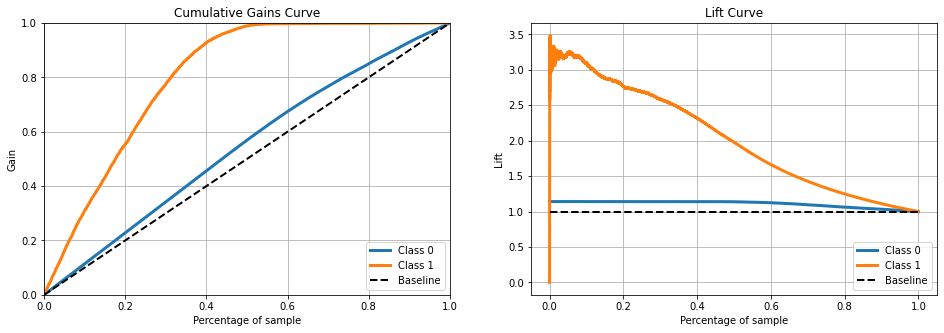

In [316]:
# model definition
xgb_model = xgb.XGBClassifier(n_estimators = 100)

# model fit
xgb_model.fit(X_train[cols_selected],Y_train)

# model predict
yhat_xgb = xgb_model.predict_proba(X_test[cols_selected])

# performance
xgb_result = single_performance('XGBoost', X_test[cols_selected], Y_test,yhat_xgb)

# plot
fig, ax = plt.subplots(1,2,figsize=(16,5))

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(Y_test,yhat_xgb,ax=ax[0])
skplt.metrics.plot_lift_curve(Y_test,yhat_xgb,ax=ax[1]);